Burada, bir önceki çalışmada kullandığımız boy uzunluğu veri kümesiyle çalışacağız tekrar. Aynı veriyi daha ayrıntılı bir yaklaşımla işleyeceğiz.

Karışım modelinde bütün popülasyonun $w_1 \phi_1(\mu_1,\sigma_1) + w_2 \phi_2(\mu_2,\sigma_2)$ biçiminde bir dağılımdan çekildiğini varsayıp, $w_1, w_2, \mu_1, \mu_2, \sigma_1, \sigma_2$ parametrelerini öğrenmiştik. Burada ağırlık faktörleri $w_1$ ve $w_2$ kullanılmayacak; onlar yerine her bir veri noktası $y_i$'nin gizli bir kategori değişkeni $k_i$'ye (0 veya 1) bağlı olduğunu varsayacağız.

Kategori (erkek veya kadın) dağılımın ortalama ve standart sapma parametrelerini belirler; parametreler ise verilerin dağılımını belirler. Böyle bir model _hiyerarşik model_ olarak anılır. Bir Bayes ağı olarak şöyle gösterebiliriz:

$$k_i \rightarrow (\mu,\sigma) \rightarrow y_i$$

Burada Bayesci çıkarım kullanarak verilerden kategoriler öğreneceğiz; yani her bir veri noktasını iki kategoriden birine yerleştireceğiz. Bu şekilde _güdümsüz sınıflandırma_ yapmış olacağız. Yan etki olarak, kategorilerin dağılım parametrelerini de öğreneceğiz.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pymc3 as pm
import pandas

Galton verisini açalım ve boy uzunluklarını ayıralım.

In [2]:
galtondf = pandas.read_csv("data/galton.txt","\t")
boylar = galtondf["Height"].values

Erkek ve kadınların ayrı ayrı boy ortalamalarını çıkaralım.

In [3]:
print("Ortalama erkek boyu:", galtondf[galtondf["Gender"]=="M"]["Height"].mean(),"inç")
print("Ortalama kadın boyu:", galtondf[galtondf["Gender"]=="F"]["Height"].mean(),"inç")

Ortalama erkek boyu: 69.22881720430114 inç
Ortalama kadın boyu: 64.11016166281759 inç


Modelimizi kuralım. Önselleri şu şekilde belirleyelim
$$\begin{eqnarray}
k_i &\sim& \mathrm{Cat}(0.5, 0.5) \\
\mu_0 &\sim& N(60,20) \\
\mu_1 &\sim& N(70,20) \\
\sigma_0 &\sim& \mathrm{Unif}(0,10)\\
\sigma_1 &\sim& \mathrm{Unif}(0,10)\\
B_i &\sim& N(\mu_{k_i}, \sigma_{k_i})
\end{eqnarray}$$

900'den fazla değişkenimiz olduğu için aşağıdaki işlemin tamamlanması birkaç dakika alacak.

In [9]:
hiy_model = pm.Model()
with hiy_model:
    k = pm.Categorical("k", np.array([0.5, 0.5]), shape = len(boylar))
    ort = pm.Normal("ort", mu = [60,70], sd = 20, shape = 2)
    stsap = pm.Uniform("stsap", lower = 0, upper = 10, shape = 2)
    B = pm.Normal("y", mu = ort[k], sd = stsap[k], observed=boylar)
    numuneler = pm.sample(1000)

Assigned BinaryGibbsMetropolis to k
Assigned NUTS to ort
Assigned NUTS to stsap_interval_
100%|██████████| 1000/1000 [06:12<00:00,  3.95it/s]


Öncelikle dağılım parametreleri $\mu_{0,1}$ ve $\sigma_{0,1}$'e bakalım.

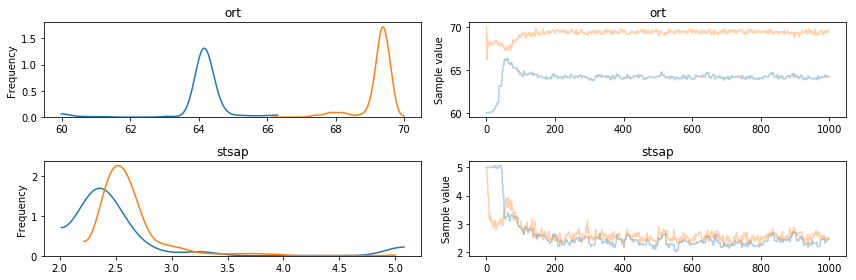

In [10]:
pm.traceplot(numuneler, varnames=[ort,stsap]);

Bir önceki çalışmada elde ettiğimiz değerlerin civarında bir sonuç elde ettik. Ancak doğru sonuç için ilk 100 numuneyi silmek gerekiyor.

In [11]:
m1, m2 = np.mean(numuneler.get_values("ort")[100:], axis=0)
print("Ortalamalar:",m1,m2)
sd1, sd2 = np.mean(numuneler.get_values("stsap")[100:], axis=0)
print("Standart sapmalar:",sd1, sd2)

Ortalamalar: 64.1650933886 69.366362631
Standart sapmalar: 2.39136132333 2.55010211379


Şimdi bu öğrenilen parametrelerle iki ayrı dağılımı çizelim, ve orijinal veriye ne kadar uyduklarına bakalım.

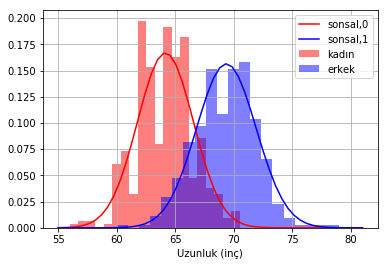

In [12]:
b = np.linspace(55,81,50)
# Sonsal parametrelerle model dağılımı
plt.plot(b,np.exp(-(b-m1)**2/(2*sd1**2))/np.sqrt(2*np.pi*sd1**2), label="sonsal,0", color="r")
plt.plot(b,np.exp(-(b-m2)**2/(2*sd2**2))/np.sqrt(2*np.pi*sd2**2), label="sonsal,1", color="b")

# Orijinal verilerin cinsiyete göre ayrılmış histogramları
erkek_boy = galtondf[galtondf["Gender"]=="M"]["Height"]
kadın_boy = galtondf[galtondf["Gender"]=="F"]["Height"]

kadın_boy.hist(bins=20, normed=True ,alpha=0.5, label="kadın", color="red")
erkek_boy.hist(bins=20, normed=True ,alpha=0.5, label="erkek", color="blue")

plt.xlabel("Uzunluk (inç)")
plt.legend();

Bu yöntem iki ayrı normal dağılım için parametreler verse de, hangisinin erkek hangisinin kadın olduğunu bilemez elbette. Sonuçlara bakarak 0 kategorisinin kadın, 1 kategorisinin erkek olduğunu anlıyoruz. Bu eşleşme her zaman böyle olmaz; simülasyonu tekrar çalıştırdığımızda ters dönmesi mümkün.

## Sınıflandırma

İki normal dağılmış öbek varsaydık ve her bir $i$ noktası için bir $k_i$ kategorik parametre değeri öğrendik. Öğrenme sırasında cinsiyet bilgisini kullanmadığımız için bu bir _güdümsüz sınıflandırma_ yöntemidir.

$k_i>0.5$ ise erkek, değilse kadın tahmini yapacağız. Buna göre ilk on kişide bir tahmin yapalım.

In [13]:
for i in range(10):
    ki = np.mean(numuneler[k][200:,i])
    print("k_"+str(i)+" =", ki, "E" if ki>0.5 else "K")

k_0 = 0.9975 E
k_1 = 0.88125 E
k_2 = 0.87125 E
k_3 = 0.885 E
k_4 = 0.99875 E
k_5 = 0.99375 E
k_6 = 0.25625 K
k_7 = 0.26 K
k_8 = 0.98625 E
k_9 = 0.77125 E


Orijinal veriye baktığımızda tahminimizin sadece başarı oranının sadece 6/10 olduğunu görüyoruz.

In [14]:
galtondf[:10]

,Family,Father,Mother,Gender,Height,Kids
0,1,78.5,67.0,M,73.2,4
1,1,78.5,67.0,F,69.2,4
2,1,78.5,67.0,F,69.0,4
3,1,78.5,67.0,F,69.0,4
4,2,75.5,66.5,M,73.5,4
5,2,75.5,66.5,M,72.5,4
6,2,75.5,66.5,F,65.5,4
7,2,75.5,66.5,F,65.5,4
8,3,75.0,64.0,M,71.0,2
9,3,75.0,64.0,F,68.0,2


Sistematik bir karşılaştırma için veri tablosuna tahminlerimizi içeren bir sütun ekleyelim.

In [15]:
# Erkek tahmin edilenlerin indeks dizisi
ind_erkek = np.mean(numuneler[k][100:,:],axis=0)>0.5
# Kadın tahmin edilenlerin indeks dizisi
ind_kadın = np.mean(numuneler[k][100:,:],axis=0)<0.5

galtondf["tahmin"]=""
galtondf["tahmin"][ind_erkek]="M"
galtondf["tahmin"][ind_kadın]="F"

/home/kaan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/kaan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
galtondf[:10]

,Family,Father,Mother,Gender,Height,Kids,tahmin
0,1,78.5,67.0,M,73.2,4,M
1,1,78.5,67.0,F,69.2,4,M
2,1,78.5,67.0,F,69.0,4,M
3,1,78.5,67.0,F,69.0,4,M
4,2,75.5,66.5,M,73.5,4,M
5,2,75.5,66.5,M,72.5,4,M
6,2,75.5,66.5,F,65.5,4,F
7,2,75.5,66.5,F,65.5,4,F
8,3,75.0,64.0,M,71.0,2,M
9,3,75.0,64.0,F,68.0,2,M


Modelin doğruluğunu (accuracy) bulmak için, doğru tahminlerin oranını kolaylıkla buluruz.

In [17]:
sum(galtondf["Gender"]==galtondf["tahmin"]) / len(galtondf)

0.84855233853006684

Kurduğumuz hiyerarşik Bayes modeli, verinin iki sınıfa ayrılmasında %85 başarılı.

### Çalışma:

Modelin başarısız olduğu durumları inceleyin (erkek zannedilen kadınlar ve kadın zannedilen erkekler). Başarısızlığı nasıl açıklayabiliriz? Daha fazla veri ile, veya MC algoritmasını dikkatle ayarlayarak başarı oranını artırabilir miyiz?

### Çözüm

Başarısız olduğu durumlara bakalım. Kadın tahmin edilen erkekler:

In [18]:
galtondf[(galtondf["Gender"]=="M") & (galtondf["tahmin"]=="F")]

,Family,Father,Mother,Gender,Height,Kids,tahmin
59,17,73.0,64.5,M,62.5,6,F
149,40,71.0,66.0,M,66.0,5,F
197,53,71.0,63.0,M,64.0,9,F
226,58,71.0,62.0,M,66.0,7,F
252,66,70.0,66.5,M,66.5,11,F
272,69,70.0,65.0,M,65.0,8,F
273,69,70.0,65.0,M,65.0,8,F
278,70,70.0,65.0,M,65.0,5,F
311,76,70.0,64.0,M,66.0,7,F
312,76,70.0,64.0,M,65.0,7,F


Bu erkekler ortalamanın epey altında görünüyorlar. Nitekim en uzun boylusu 66.7 inç. Erkeklerin eğrisinin sol ucundalar.

In [19]:
galtondf[(galtondf["Gender"]=="M") & (galtondf["tahmin"]=="F")]["Height"].max()

66.700000000000003

Keza, erkek zannedilen kadınların boyları da kendi gruplarının ortalamasının epey üstünde. En kısası, ortalamadan üç inç uzun.

In [20]:
galtondf[(galtondf["Gender"]=="F") & (galtondf["tahmin"]=="M")]["Height"].min()

67.0

Verinin histogramına tekrar bakarak meseleyi daha iyi anlayabiliriz: İki dağılım birbirinden tamamen ayrışmış değil. Hatalar iki dağılımın kesiştiği yerde bulunuyor.

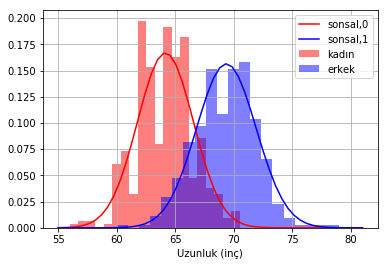

In [21]:
b = np.linspace(55,81,50)
# Sonsal parametrelerle model dağılımı
plt.plot(b,np.exp(-(b-m1)**2/(2*sd1**2))/np.sqrt(2*np.pi*sd1**2), label="sonsal,0", color="r")
plt.plot(b,np.exp(-(b-m2)**2/(2*sd2**2))/np.sqrt(2*np.pi*sd2**2), label="sonsal,1", color="b")

# Orijinal verilerin cinsiyete göre ayrılmış histogramları
erkek_boy = galtondf[galtondf["Gender"]=="M"]["Height"]
kadın_boy = galtondf[galtondf["Gender"]=="F"]["Height"]

kadın_boy.hist(bins=20, normed=True ,alpha=0.5, label="kadın", color="red")
erkek_boy.hist(bins=20, normed=True ,alpha=0.5, label="erkek", color="blue")

plt.xlabel("Uzunluk (inç)")
plt.legend();

Bu grafiğe bakınca daha fazla veri toplamanın, veya daha iyi bir algoritmanın hata oranını fazla azaltamayacağını görüyoruz. Daha fazla veri, dağılımların daha ayrışmasına sebep olmayacak. Bu problemde yüzde yüze yakın bir başarı oranı mümkün değil.